# Predicting the Status of Wells Across Tanzania

Exploration done by WellWatchers Avi Saraf, Lily Zhang, and Cindy Zhao.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

###Data preparation

In [4]:
df_values = pd.read_csv("clean_training_set_values.csv")
df_labels = pd.read_csv("training_set_labels.csv")

In [5]:
#merge the features (i.e. values) and the labels into one DataFrame
df = pd.merge(df_values, df_labels, on="id")

In [6]:
df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,date_recorded_offset_days,date_recorded_month,status_group
0,69572,6000,Other,1390,Other,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1024,Mar,functional
1,8776,0,Other,1399,Other,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,301,Mar,functional
2,34310,25,Other,686,Other,37.460664,-3.821329,Pangani,Majengo,Manyara,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,310,Feb,functional
3,67743,0,Unicef,263,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,338,Jan,non functional
4,19728,0,Other,0,Other,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,903,Jul,functional


#Exploratory analysis

##Categorical Features

We have the following categorical variables:
- funder
- installer
- basin
- subvillage
- region
- scheme_management
- management
- management_group
- public_meeting (T/F)
- permit (T/F)
- extraction_type
- extraction_type_group
- extraction_type_class
- payment
- payment_type
- water_quality
- quality_group
- waterpoint_type
- waterpoint_type_group

Here we see the unique values under the columns with categorical values.

###Redundancies
We see that some of the columns describe the same feature but have slightly different sets of values. This is particularly the case with features that also have a corresponding '_ _group_' column as well. For now, we will stick with the non-gropu features because they are more specific.

In [5]:
print pd.Series(df.extraction_type.ravel()).unique()
#less specific
print pd.Series(df.extraction_type_group.ravel()).unique()
print pd.Series(df.extraction_type_class.ravel()).unique()

['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi']
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


In [6]:
#equivalent
print pd.Series(df.payment.ravel()).unique()
print pd.Series(df.payment_type.ravel()).unique()

['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']


In [7]:
#the difference here is the addition of 'communal standpipe multiple' in waterpoint_type
print pd.Series(df.waterpoint_type.ravel()).unique()
#less specific
print pd.Series(df.waterpoint_type_group.ravel()).unique()

['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
['communal standpipe' 'hand pump' 'other' 'improved spring' 'cattle trough'
 'dam']


In [8]:
print pd.Series(df.water_quality.ravel()).unique()
#less specific
print pd.Series(df.quality_group.ravel()).unique()

['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']


In [9]:
#less specific
#'borehole' includes 'machine dbh' and 'hand dtw'
#'river/lake' includes 'river' and 'lake'
#'other' includes 'other' and 'unknown'
print pd.Series(df.source_type.ravel()).unique()
print pd.Series(df.source.values.ravel()).unique()
#source and source_type are nested within source_class
print pd.Series(df.source_class.values.ravel()).unique()

['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other' 'shallow well'
 'river' 'hand dtw' 'lake' 'unknown']
['groundwater' 'surface' 'unknown']


In [10]:
#management is nested within management_group
print pd.Series(df.management.ravel()).unique()
print pd.Series(df.management_group.ravel()).unique()

['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
['user-group' 'other' 'commercial' 'parastatal' 'unknown']


We see that some of these features are redundant, so we delete one of the columns of these repeats. Regarding the features/feature_group label pairs, there is a nesting structure but it is so slight that we just delete one of the columns; otherwise, we would most likely run into problems of collinearity. We have two new dataframes, one with only the feature_group labels (less specific), and one with only the feature labels (more specific). We will try our regression on the less specific df_new first but keep df_new1 just in case.

In [7]:
df_new1 = df.drop(['quantity_group','extraction_type_group','waterpoint_type_group','quality_group','source_type','payment', 'construction_year','latitude','longitude', 'subvillage','id'], axis=1)
df_new = df.drop(['quantity_group','extraction_type','waterpoint_type','quality_group','source','payment', 'construction_year','latitude','longitude','subvillage','id'], axis=1)

In [27]:
df_new.head()

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,...,management_group,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type_group,date_recorded_offset_days,date_recorded_month,status_group
0,6000,Other,1390,Other,Lake Nyasa,Iringa,109,True,VWC,False,...,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1024,Mar,functional
1,0,Other,1399,Other,Lake Victoria,Mara,280,NaN,Other,True,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,301,Mar,functional
2,25,Other,686,Other,Pangani,Manyara,250,True,VWC,True,...,user-group,per bucket,soft,enough,dam,surface,communal standpipe,310,Feb,functional
3,0,Unicef,263,Other,Ruvuma / Southern Coast,Mtwara,58,True,VWC,True,...,user-group,never pay,soft,dry,borehole,groundwater,communal standpipe,338,Jan,non functional
4,0,Other,0,Other,Lake Victoria,Kagera,0,True,NaN,True,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,903,Jul,functional


###Nestings

In df_new, we know that:
- management is nested within management_group
- source is nested within source_class
- extraction is nested within extraction_type_class
- subvillage is nested within region

###Grouping the types of categorical variables
The features dealing with the management of the well include:
- funder
- installer
- scheme_management
- management/management_group
- payment_type
- permit (T/F)

The features dealing with the creation of the well include:
- extraction/extraction_type_class
- waterpoint_type

The features dealing with time include: 
- construction_year
- date_recorded_offset_days (int; how long ago it was constructed, from the date recorded)
- date_recorded_month

The features dealing with natural properties include:
- water_quality
- source/source_class
- amount_tsh
- quantity
- basin

The features dealing with the community using the well and location include:
- subvillage
- region
- population
- public_meeting (T/F)
- gps_height
- longitude
- latitude

In [9]:
df_new.columns

Index([u'amount_tsh', u'funder', u'gps_height', u'installer', u'basin',
       u'subvillage', u'region', u'population', u'public_meeting',
       u'scheme_management', u'permit', u'extraction_type_group',
       u'extraction_type_class', u'management', u'management_group',
       u'payment_type', u'water_quality', u'quantity', u'source_type',
       u'source_class', u'waterpoint_type_group', u'date_recorded_offset_days',
       u'date_recorded_month', u'status_group'],
      dtype='object')

##Splitting the training and testing data


In [9]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(xrange(df_new.shape[0]), train_size=0.7)
mask=np.ones(df_new.shape[0])
mask[train]=1
mask[test]=0
mask = (mask==1)

##Standardize
Now standardize our quantitative variables so they can be compared. These variables are amount_tsh, gps_height, population, and date_recorded_offset_days.

In [10]:
from sklearn import preprocessing as prepr
STANDARDIZABLE = [u'amount_tsh', u'gps_height', u'population', u'date_recorded_offset_days']
scaler = prepr.StandardScaler().fit(df_new[mask][STANDARDIZABLE])
df_new[STANDARDIZABLE] = scaler.transform(df_new[STANDARDIZABLE])
df_new[STANDARDIZABLE].head()

,amount_tsh,gps_height,population,date_recorded_offset_days
0,1.831495,1.042939,-0.148715,1.135927
1,-0.101290,1.055942,0.205933,-1.021636
2,-0.093236,0.025834,0.143714,-0.994778
3,-0.101290,-0.585296,-0.254488,-0.911221
4,-0.101290,-0.965266,-0.374778,0.774841


##Visualizing the feature variables
Let's plot these variables now and see how their distributions differ across the functional, non functional, and needs repair wells. 

In [11]:
# fig, axes = plt.subplots(nrows=2, ncols=2)

# for i, feature in enumerate(STANDARDIZABLE):
#     ax = axes[i/2, i%2]
#     sns.kdeplot(df_new[df_new['status_group']=='functional'][feature], ax=ax, shade=True,color='green', label="Functional wells")
#     sns.kdeplot(df_new[df_new['status_group']=='non functional'][feature], ax=ax, shade=True,color='red', label="Non Functional Wells")
#     sns.kdeplot(df_new[df_new['status_group']=='functional needs repair'][feature], ax=ax, shade=True,color='blue', label="Wells that Need Repair")
#     ax.set_title(feature)
# fig.tight_layout()

We do the same for the categorical variables.

In [12]:
CATEGORICAL = [u'funder', u'installer', u'basin', u'region',
               u'public_meeting', u'scheme_management', u'permit',
               u'extraction_type_group', u'extraction_type_class',
               u'management', u'management_group', u'payment_type', u'water_quality',
               u'quantity', u'source_type', u'source_class', u'waterpoint_type_group', u'date_recorded_month']
for variable in CATEGORICAL:
    df_new[variable] = df_new[variable].astype('category')  

In [13]:
# fig1, axes1 = plt.subplots(5,4)

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 
# for j, variable in enumerate(CATEGORICAL):
#     ax1 = axes1[j/4,j%4]
#     functional = df_new[df_new['status_group']=='functional'][variable].tolist()
#     non_functional = df_new[df_new['status_group']=='non functional'][variable].tolist()
#     needs_repair = df_new[df_new['status_group']=='functional needs repair'][variable].tolist()
#     categories = pd.Series(df_new[variable].values.ravel()).unique()
#     value_freq_funct = []
#     value_freq_nonf = []
#     value_freq_repair = []
#     categories_num = range(1,len(categories)+1)
#     for value in categories:
#         value_freq_funct.append(functional.count(value))
#         value_freq_nonf.append(non_functional.count(value))
#         value_freq_repair.append(needs_repair.count(value))
#     ax1.bar(categories_num,value_freq_funct,align='center',color='g')
#     ax1.bar(categories_num,value_freq_nonf,align='center',color='r')
#     ax1.bar(categories_num,value_freq_repair,align='center',color='b')
#     ax1.set_xticklabels(categories)
#     ax1.legend()
#     ax1.set_title(variable)
# plt.tight_layout()

Let's take a closer look at some of them. In particular, ___ seem to show very interesting distributions.

In [15]:
##To run
#for subvillages
# functional = df_new[df_new['status_group']=='functional']['subvillage'].tolist()
# non_functional = df_new[df_new['status_group']=='non functional']['subvillage'].tolist()
# needs_repair = df_new[df_new['status_group']=='functional needs repair']['subvillage'].tolist()

# plt.rc('xtick', labelsize=12) 
# plt.rc('ytick', labelsize=12)

# categories = pd.Series(df_new.subvillage.values.ravel()).unique()
# value_freq_funct = []
# value_freq_nonf = []
# value_freq_repair = []
# categories_num = range(1,len(categories)+1)
# for value in categories:
#     value_freq_funct.append(functional.count(value))
#     value_freq_nonf.append(non_functional.count(value))
#     value_freq_repair.append(needs_repair.count(value))
# fig, [ax1, ax2, ax3] = plt.subplots(3, 1)
# ax1.bar(categories_num,value_freq_funct,align='center',color='g')
# ax2.bar(categories_num,value_freq_nonf,align='center',color='r')
# ax3.bar(categories_num,value_freq_repair,align='center',color='b')
#plt.xticks(categories_num, categories)

([<matplotlib.axis.XTick at 0x10d713410>,
 <a list of 11 Text xticklabel objects>)

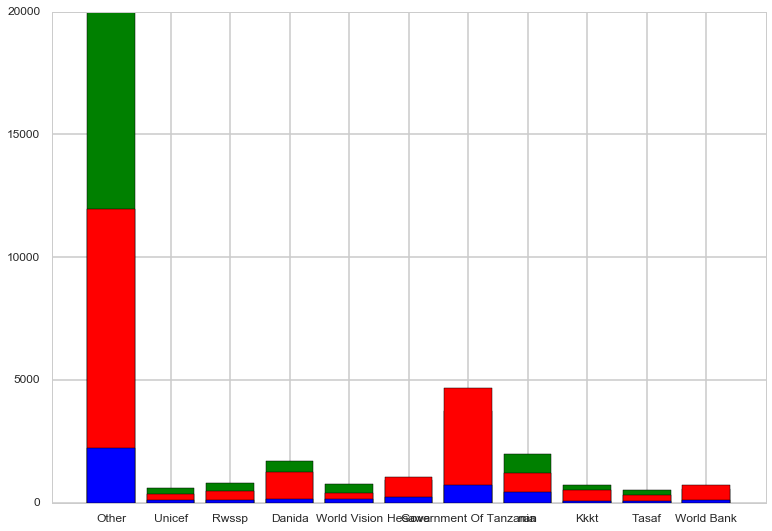

In [17]:
#for funders
functional = df_new[df_new['status_group']=='functional']['funder'].tolist()
non_functional = df_new[df_new['status_group']=='non functional']['funder'].tolist()
needs_repair = df_new[df_new['status_group']=='functional needs repair']['funder'].tolist()

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

categories = pd.Series(df_new.funder.values.ravel()).unique()
value_freq_funct = []
value_freq_nonf = []
value_freq_repair = []
categories_num = range(1,len(categories)+1)
for value in categories:
    value_freq_funct.append(functional.count(value))
    value_freq_nonf.append(non_functional.count(value))
    value_freq_repair.append(needs_repair.count(value))

plt.bar(categories_num,value_freq_funct,align='center',color='g')
plt.bar(categories_num,value_freq_nonf,align='center',color='r')
plt.bar(categories_num,value_freq_repair,align='center',color='b')
plt.xticks(categories_num, categories)

In [18]:
pd.Series(df.funder.values.ravel()).unique()

array(['Other', 'Unicef', 'Rwssp', 'Danida', 'World Vision', 'Hesawa',
       'Government Of Tanzania', nan, 'Kkkt', 'Tasaf', 'World Bank'], dtype=object)

#Models


Because we are working with a lot of categorical feature data, we first need to turn the multiclass feature variables into indicators for each of the possible values.

In [19]:
#df_formatted includes all the data from df_new, with the categorical variables as indicators
df_formatted = pd.get_dummies(df_new, columns=CATEGORICAL)
df_formatted.head()

,amount_tsh,gps_height,population,date_recorded_offset_days,status_group,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Kkkt,funder_Other,...,date_recorded_month_Dec,date_recorded_month_Feb,date_recorded_month_Jan,date_recorded_month_Jul,date_recorded_month_Jun,date_recorded_month_Mar,date_recorded_month_May,date_recorded_month_Nov,date_recorded_month_Oct,date_recorded_month_Sep
0,1.831495,1.042939,-0.148715,1.135927,functional,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,-0.101290,1.055942,0.205933,-1.021636,functional,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,-0.093236,0.025834,0.143714,-0.994778,functional,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,-0.101290,-0.585296,-0.254488,-0.911221,non functional,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-0.101290,-0.965266,-0.374778,0.774841,functional,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [20]:
#feat_train and lab_train analogous to Xtrain and ytrain
feat_train = df_formatted[mask].drop('status_group',axis=1)
lab_train = pd.DataFrame(df_formatted[mask].status_group)
##feat_test and lab_test analogous to Xtrain and ytrain
feat_test = df_formatted[~mask].drop('status_group',axis=1)
lab_test = pd.DataFrame(df_formatted[~mask].status_group)

##Naive Bayes

We begin with Naive Bayes to set up a baseline classifier. While the probabilities may not be too well calibrated, the relative order of of the probabilities across the labels is typically correct.

Because we have a combination of categorical and continuous predictors, we first independently fit a Gaussian Naive Bayes model on the continuous data and a bernoulli Naive Bayes model on the categorical part. 

####TO DECIDE

Then we __________ transform the entire dataset by taking the class assignment probabilities (with the predict_proba() method) as the new features: np.hstack((multinomial_probas, gaussian_probas)) and then refit a new model (e.g. a new gaussian NB) on these new features.

calibrate (show plot)
log -> sum

In [56]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

#separate categorical and continuous
cont_feat_train = feat_train[STANDARDIZABLE].values
cat_feat_train = feat_train.drop(STANDARDIZABLE,axis=1).values
cont_feat_test = feat_test[STANDARDIZABLE].values
cat_feat_test = feat_test.drop(STANDARDIZABLE,axis=1).values

In [57]:
#fit the continuous variables to a Gaussian Naive Bayes
gnb_clf = GaussianNB()
gnb_clf.fit(cont_feat_train, lab_train)
print "Frac of correctly labeled points",float((lab_test.values.transpose().tolist() == gnb_clf.predict(cont_feat_test)).sum())/lab_test.shape[0]
confusion_matrix(gnb_clf.predict(cont_feat_test),lab_test)

Frac of correctly labeled points 0.425869809203


array([[1025,   71,  319],
       [   0,    0,    0],
       [8617, 1224, 6564]])

In [58]:
#fit the categorical variables to a Bernoulli Naive Bayes
bnb_clf = BernoulliNB()
bnb_clf.fit(cat_feat_train, lab_train)

print "Frac of correctly labeled points",float((lab_test.values.transpose().tolist() == bnb_clf.predict(cat_feat_test)).sum())/lab_test.shape[0]
confusion_matrix(bnb_clf.predict(cat_feat_test),lab_test)

Frac of correctly labeled points 0.655274971942


array([[7042,  545, 2125],
       [ 955,  471,  594],
       [1645,  279, 4164]])

In [63]:
#fit the categorical variables to a Multinomial Naive Bayes
mnb_clf = MultinomialNB()
mnb_clf.fit(cat_feat_train, lab_train)

print "Frac of correctly labeled points",float((lab_test.values.transpose().tolist() == mnb_clf.predict(cat_feat_test)).sum())/lab_test.shape[0]
confusion_matrix(mnb_clf.predict(cat_feat_test),lab_test)

Frac of correctly labeled points 0.677665544332


array([[7590,  647, 2425],
       [ 640,  384,  356],
       [1412,  264, 4102]])

Naive Bayes does not work well with highly correlated features because the conditional independence assumption of Naive Bayes overinflates the importance of these correlated features by in effect counting them twice. Thus, we remove some of the redundant features, particularly the more broad feature in the nesting structures.

In [64]:
small_df_new = df_new.drop(['management_group','source_class','extraction_type_class'], axis=1)
small_df_formatted = pd.get_dummies(small_df_new, columns=list(set(CATEGORICAL).difference(['management_group','source_class','extraction_type_class'])))


reduced_feat_train = small_df_formatted[mask].drop('status_group',axis=1)
reduced_feat_test = small_df_formatted[~mask].drop('status_group',axis=1)

cont_feat_train1 = reduced_feat_train[STANDARDIZABLE].values
cat_feat_train1 = reduced_feat_train.drop(STANDARDIZABLE,axis=1).values
cont_feat_test1 = reduced_feat_test[STANDARDIZABLE].values
cat_feat_test1 = reduced_feat_test.drop(STANDARDIZABLE,axis=1).values

In [65]:
gnb_clf1 = GaussianNB()
gnb_clf1.fit(cont_feat_train1, lab_train)
print "Frac of correctly labeled points",float((lab_test.values.transpose().tolist() == gnb_clf1.predict(cont_feat_test1)).sum())/lab_test.shape[0]
confusion_matrix(gnb_clf1.predict(cont_feat_test1),lab_test)

Frac of correctly labeled points 0.425869809203


array([[1025,   71,  319],
       [   0,    0,    0],
       [8617, 1224, 6564]])

In [66]:
#fit the categorical variables to a Bernoulli Naive Bayes
bnb_clf1 = BernoulliNB()
bnb_clf1.fit(cat_feat_train1, lab_train)

print "Frac of correctly labeled points",float((lab_test.values.transpose().tolist() == bnb_clf1.predict(cat_feat_test1)).sum())/lab_test.shape[0]
confusion_matrix(bnb_clf1.predict(cat_feat_test1),lab_test)

Frac of correctly labeled points 0.669977553311


array([[7170,  568, 2172],
       [ 730,  427,  369],
       [1742,  300, 4342]])

We have a higher accuracy, yet we can still do better. We know that the Bernoulli model factors into account the nonoccurence of the different features. As a result, it puts more weight on the features that have many values associated, not factoring in inherent dependence and mutually exclusive nature of these feature. For example, if a row has a 1 for funder World Bank, it will have a 0 for all the other funders, and the Bernoulli model will take into account the 1 and all the 0s, despite them being very dependent.

We instead fit the model for categorical feature variables to a Multinomial Naive Bayes. The model performs better, as shown below.

In [67]:
#fit the categorical variables to a Multinomial Naive Bayes
mnb_clf1 = MultinomialNB()
mnb_clf1.fit(cat_feat_train1, lab_train)

print "Frac of correctly labeled points",float((lab_test.values.transpose().tolist() == mnb_clf1.predict(cat_feat_test1)).sum())/lab_test.shape[0]
confusion_matrix(mnb_clf1.predict(cat_feat_test1),lab_test)

Frac of correctly labeled points 0.688496071829


array([[7673,  673, 2388],
       [ 489,  328,  227],
       [1480,  294, 4268]])

Since we split the categorical and quantitative features, we did not get to use all our features. To allow for that, we bucket our quantitative features to turn them into categorical ones. We bucket them how we deem appropriate according to the graphs above.

In [68]:
#turn quantitative variables to categorical ones
df_allcat = small_df_new.copy()

df_allcat.ix[df_allcat.amount_tsh>40, 'amount_tsh'] = "High"
df_allcat.ix[(df_allcat.amount_tsh>10) & (df_new.amount_tsh<=40), 'amount_tsh'] = "Medium"
df_allcat.ix[df_allcat.amount_tsh<=10, 'amount_tsh'] = "Low"

df_allcat.ix[df_allcat.gps_height>0, 'gps_height'] = "Above avg"
df_allcat.ix[df_allcat.gps_height<=0, 'gps_height'] = "Below avg"

df_allcat.ix[df_allcat.date_recorded_offset_days>0, 'date_recorded_offset_days'] = "Above avg"
df_allcat.ix[df_allcat.date_recorded_offset_days<=0, 'date_recorded_offset_days'] = "Below avg"

df_allcat.ix[df_allcat.population>10, 'population'] = "High"
df_allcat.ix[(df_allcat.population<10)&(df_allcat.population>0), 'population'] = "Medium"
df_allcat.ix[df_allcat.population<=0, 'population'] = "Low"


In [69]:
df_allcat = df_allcat.drop('status_group',axis=1)
df_allcat_formatted = pd.get_dummies(df_allcat)

new_feat_train = df_allcat_formatted[mask]
new_feat_test = df_allcat_formatted[~mask]

In [71]:
#fit all variables to a Multinomial Naive Bayes
mnb_clf2 = MultinomialNB()
mnb_clf2.fit(new_feat_train, lab_train)

print "Frac of correctly labeled points",float((lab_test.values.transpose().tolist() == mnb_clf2.predict(new_feat_test)).sum())/lab_test.shape[0]
confusion_matrix(mnb_clf2.predict(new_feat_test),lab_test)

 Frac of correctly labeled points 0.682940516274


array([[7597,  668, 2392],
       [ 493,  333,  251],
       [1552,  294, 4240]])

We now plat a calibration plot for our full Multinomial NB model, as well as the Multinomial NB on the reduced list of categorical variables.

In [108]:
#TODO: make it work for ytest being categorical
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical Fraction")

    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    #calsum = cal['count'].sum()
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    plt.xlabel("Classifier Probability")

In [ ]:
calibration_plot(mnb_clf1, cont_feat_test1, lab_test)

In [ ]:
calibration_plot(mnb_clf2, new_feat_test, lab_test)

In [102]:
# #TODO
# #optimize with Fisher's method
# #combine for mixed Bayes?

# #find the probabilities for the Multinomial and Gaussian Naive Bayes
# gnb_probs = gnb_clf1.predict_proba(cont_feat_train1)
# mnb_probs = mnb_clf1.predict_proba(cat_feat_train1)

# #combine
# feat_probs = np.hstack((gnb_probs, mnb_probs))

# nb_clf = GaussianNB()
# #nb_clf.fit(feat_probs, lab_train)
# feat_probs = nb_clf.predict_proba(feat_test)
# print reduced_feat_test.shape
# print feat_probs
# print '***'
# print mnb_probs
# print '***'
# print cat_feat_train1.shape
# #don't know how to change the inputs to probabilities 
# # print "Frac of mislabeled points",float((lab_test.values.transpose().tolist() != nb_clf.predict(reduced_feat_test)).sum())/lab_test.shape[0]
# # confusion_matrix(nb_clf.predict(reduced_feat_test),lab_test)

(17820, 139)
[[ 0.29493591  0.07536548  0.62969861  0.75753708  0.06756535  0.17489756]
 [ 0.21525895  0.05865076  0.72609029  0.57245036  0.30492416  0.12262548]
 [ 0.19871927  0.07104323  0.73023751  0.70299508  0.03008168  0.26692324]
 ..., 
 [ 0.26510723  0.07571938  0.65917339  0.99126605  0.00300007  0.00573388]
 [ 0.22146002  0.05497675  0.72356323  0.88664278  0.05290528  0.06045194]
 [ 0.22398112  0.05357364  0.72244524  0.71583435  0.02800989  0.25615576]]
***
[[ 0.75753708  0.06756535  0.17489756]
 [ 0.57245036  0.30492416  0.12262548]
 [ 0.70299508  0.03008168  0.26692324]
 ..., 
 [ 0.99126605  0.00300007  0.00573388]
 [ 0.88664278  0.05290528  0.06045194]
 [ 0.71583435  0.02800989  0.25615576]]
***
(41580, 135)


The one problem with this above approach, however, is that .predict_proba(X) method will return posteriors normalized over all classes. What we want is the unnormalized probabilities so that we can multiply them together. However, if they are normalized differently (which they are, since they are normalized for the classes), the product of such probabilities is not very reliable.http://stats.stackexchange.com/questions/93928/naive-bayes-continuous-and-categorical-predictors

Since mixing the Gaussian and Multinomial models is rather difficult, we move to a model that can more easily include both: the SVM.

##SVM

Add Cindy's code

##Optimizing the hyperparameters

Now we write two functions: cv_optimize() use GridSearchCV to choose the best regularization hyperparameter for the model, and do_classify() to print out the model fit on the training and test sets.

In [22]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

Here, we use the score() function in sklearn.linear_model.LogisticRegression. Other model evaluation/comparison measures we could consider are the balanced F-score (sklearn.metrics.f1_score()), the Kappa Statistic, Confusion Matrix, Hamming Loss, and Zero One loss. More options can be found here: http://scikit-learn.org/stable/modules/model_evaluation.html. (#TODO if more time)

In [23]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

##Regression

Because we have a categorical outcome variable with more than one outcome, we conduct a multinomial logistic regression with LASSO (specifically, L2) regularization.

Based on the visualizations up above, with 1. the wells shown in their respective geographic locations and 2. the proportion of functional/non functional/functional-needs-repair different across regions and subvillages, we sense that there may be some sort of clustering of wells by subvillage and region. Thus, we first create a multilevel model with two levels, one for the individual wells and the second for the subvillages. This creates a different correlation structure between the data points based on what group they are in.

In [49]:
##classifier without optimizing for C
mlr_clf = LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial')

In [53]:
mlr_clf = mlr_clf.fit(feat_train, lab_train)

/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
training_accuracy = mlr_clf.score(feat_train, lab_train)
test_accuracy = mlr_clf.score(feat_test, lab_test)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(lab_test, mlr_clf.predict(feat_test))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.74
Accuracy on test data:     0.73
[[8592   76 1045]
 [ 932   96  245]
 [2451   45 4338]]
########################################################


Let's take a look at the fitted model itself and interpret the coefficients. #TODO

In [172]:
mlr_clf.intercept_

array([ 1.20513196, -1.51050906,  0.3053771 ])

In [28]:
mlr_clf2 = LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial',C=1000)
mlr_clf2 = mlr_clf2.fit(feat_train, lab_train)
training_accuracy = mlr_clf2.score(feat_train, lab_train)
test_accuracy = mlr_clf2.score(feat_test, lab_test)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(lab_test, mlr_clf2.predict(feat_test))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.74
[[8616   52  958]
 [ 950  107  236]
 [2437   45 4419]]
########################################################


/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#TODO:
# -Mixed Naive Bayes
# -interpret regression coefficients
# -MLM
# -Thresholdout

In [104]:
feat_cols=list(df_formatted.columns)
feat_cols.remove(u'status_group')
%time
clfmlr, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial'), 
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted,feat_cols, u'status_group',1, mask=mask)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 25 µs
using mask


KeyboardInterrupt: 

##Random Forest

Here we run a Random Forest, optimizing for the number of trees and the number of features to consider for the best split each time.

In [26]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df_formatted, feat_cols, 'status_group', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask


/Users/lilyzhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 19} 0.775157654197 [mean: 0.72833, std: 0.00083, params: {'n_estimators': 1}, mean: 0.74226, std: 0.00480, params: {'n_estimators': 2}, mean: 0.75475, std: 0.00339, params: {'n_estimators': 3}, mean: 0.75988, std: 0.00219, params: {'n_estimators': 4}, mean: 0.76246, std: 0.00271, params: {'n_estimators': 5}, mean: 0.76741, std: 0.00355, params: {'n_estimators': 6}, mean: 0.76726, std: 0.00414, params: {'n_estimators': 7}, mean: 0.76844, std: 0.00236, params: {'n_estimators': 8}, mean: 0.76959, std: 0.00292, params: {'n_estimators': 9}, mean: 0.77053, std: 0.00252, params: {'n_estimators': 10}, mean: 0.77259, std: 0.00269, params: {'n_estimators': 11}, mean: 0.77458, std: 0.00554, params: {'n_estimators': 12}, mean: 0.77424, std: 0.00350, params: {'n_estimators': 13}, mean: 0.77482, std: 0.00265, params: {'n_estimators': 14}, mean: 0.77111, std: 0.00265, params: {'n_estimators': 15}, mean: 0.77495, std: 0.00308, params: {'n_estimators': 16}, mean: 0.77211, std: 0.0

/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/lilyzhang/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring

In [37]:
#get number of trees (n_estimators)
len(clfForest.estimators_)

19

We see that this is at the maximum of our range. Thus, we increase the the range that we optimize over during our GridSearchCV.

In [38]:
clfForest1 = RandomForestClassifier()

parameters = {"n_estimators": range(18, 40)}
clfForest1, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest1, parameters, 
                                                       df_formatted, feat_cols, 'status_group', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'n_estimators': 35} 0.778466619244 [mean: 0.77501, std: 0.00407, params: {'n_estimators': 18}, mean: 0.77566, std: 0.00340, params: {'n_estimators': 19}, mean: 0.77478, std: 0.00217, params: {'n_estimators': 20}, mean: 0.77414, std: 0.00359, params: {'n_estimators': 21}, mean: 0.77384, std: 0.00377, params: {'n_estimators': 22}, mean: 0.77621, std: 0.00379, params: {'n_estimators': 23}, mean: 0.77677, std: 0.00243, params: {'n_estimators': 24}, mean: 0.77611, std: 0.00332, params: {'n_estimators': 25}, mean: 0.77626, std: 0.00266, params: {'n_estimators': 26}, mean: 0.77535, std: 0.00259, params: {'n_estimators': 27}, mean: 0.77447, std: 0.00437, params: {'n_estimators': 28}, mean: 0.77710, std: 0.00270, params: {'n_estimators': 29}, mean: 0.77541, std: 0.00309, params: {'n_estimators': 30}, mean: 0.77555, std: 0.00386, params: {'n_estimators': 31}, mean: 0.77681, std: 0.00338, params: {'n_estimators': 32}, mean: 0.77601, std: 0.00288, params: {'n_estimators': 33}, mea

We check that we have not hit the boundary of the range we gave and indeed found an optimal value.

In [39]:
len(clfForest1.estimators_)

35

In the above classifier, we set the max_depth to None, meaning nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples (in this case, 2). We try limiting the max depth by increasing the min_samples_split size to see if this improves our performance, especially since it seems like the above classifier is overfitting to the training set. Thus we add min_sample_split to parameters to optimize.

In [45]:
clfForest2 = RandomForestClassifier()

parameters = {"n_estimators": range(18,40), "min_samples_split": range(2,10)}
clfForest2, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest2, parameters, 
                                                       df_formatted, feat_cols, 'status_group', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
BEST {'min_samples_split': 7, 'n_estimators': 35} 0.785534530765 [mean: 0.77548, std: 0.00265, params: {'min_samples_split': 2, 'n_estimators': 18}, mean: 0.77365, std: 0.00286, params: {'min_samples_split': 2, 'n_estimators': 19}, mean: 0.77474, std: 0.00464, params: {'min_samples_split': 2, 'n_estimators': 20}, mean: 0.77358, std: 0.00425, params: {'min_samples_split': 2, 'n_estimators': 21}, mean: 0.77479, std: 0.00304, params: {'min_samples_split': 2, 'n_estimators': 22}, mean: 0.77505, std: 0.00263, params: {'min_samples_split': 2, 'n_estimators': 23}, mean: 0.77447, std: 0.00370, params: {'min_samples_split': 2, 'n_estimators': 24}, mean: 0.77594, std: 0.00305, params: {'min_samples_split': 2, 'n_estimators': 25}, mean: 0.77633, std: 0.00371, params: {'min_samples_split': 2, 'n_estimators': 26}, mean: 0.77552, std: 0.00422, params: {'min_samples_split': 2, 'n_estimators': 27}, mean: 0.77548, std: 0.00369, params: {'min_samples_split': 2, 'n_estimators': 28}, mean: 0.77

##Thresholdout

There is a problem with using and reusing the test set to estimate the accuracy of a model. Specifically, we run into problems of overfitting since we use the results of on test set to adapt the model over multiple iteration, so that when we fit to the test set the nth time, the model is no longer completely independent of the test set that helped refine it in the previous example. Based on the findings of a recent paper that came out in _Science_, "The reusable holdout: Preserving validity in adaptive data analysis," we run a Thresholdout, where we add noise to the holdout set, or test set, every time we use it. Based on the relative accuracy measurements on the test and training set, we take either the training set's accuracy measurement of the test set's accuracy measurement plus random noise. We have a maximum number of times we can iterate based on the variance we allow in our measurements and the size of the holdout set. More information can be found here: http://arxiv.org/pdf/1506.02629v1.pdf and https://www.sciencemag.org/content/349/6248/636.short.

We added this functionality to do_classify in the function do_classify2().

#Visualization

In order to create the following, we first install basemap with 'conda install basemap.'

In [168]:
from mpl_toolkits.basemap import Basemap

# setup Lambert Conformal basemap.
m = Basemap(projection='cyl',
            resolution='h',
            lat_0=-6,lon_0=34., 
            llcrnrlon=25, llcrnrlat=-12,
            urcrnrlon=43, urcrnrlat=0)

# draw coastlines.
m.drawcoastlines()

# draw countries borders.
m.drawcountries()

# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')

# fill continents, set lake color same as ocean color.
m.fillcontinents(color='white',lake_color='aqua', zorder = 0)

# create scatter plot
use_colors = {"functional": "green", "non functional": "red", "functional needs repair": "blue"}
m.scatter(df_new.longitude.values, df_new.latitude.values, marker = 'o',zorder = 1, latlon=True, alpha = 0.05, 
          c=[use_colors[x] for x in df_new.status_group],s=30,lw=0)

# create legend
line1 = plt.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue", markersize = 6)
line2 = plt.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="green", markersize = 6)
line3 = plt.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="red", markersize = 6)
plt.legend((line1,line2,line3),("functional need repair","functional","non functional"),numpoints=1, loc=1)

plt.show()

ImportError: No module named basemap